# QOSF Problem-1: Generating a Random State Using Parametric Circuits

In this program, we will use multi-layer ansatz circuits to generate a random 4-qubit state. We will also see how the optimization error depends on the number of layers. 

We will be coding using IBM's open-source Quantum SDK QISKit. 

In [1]:
import numpy as np 
np.random.seed(20)

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# Building Blocks of The Parametric Circuit

## Odd Block

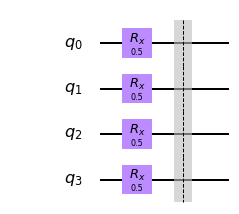

In [2]:
# defining odd block
def oddblock(params):
    qc = QuantumCircuit(4)
    
    qc.rx(params[0], 0)
    qc.rx(params[1], 1)
    qc.rx(params[2], 2)
    qc.rx(params[3], 3)
    
    qc.barrier()
    
    return qc

# visualizing oddblock to check
oddblock([0.5, 0.5, 0.5, 0.5]).draw(output='mpl')

## Even Block

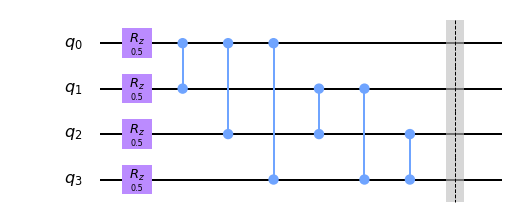

In [3]:
#defining even block

def evenblock(params):
    qc = QuantumCircuit(4)
    
    qc.rz(params[0], 0)
    qc.rz(params[1], 1)
    qc.rz(params[2], 2)
    qc.rz(params[3], 3)
    
    qc.cz(0, 1)
    qc.cz(0, 2)
    qc.cz(0, 3)
    
    qc.cz(1, 2)
    qc.cz(1, 3)
    
    qc.cz(2, 3)
    
    qc.barrier()
    
    return qc

# visualizing evenblock to check
evenblock([0.5, 0.5, 0.5, 0.5]).draw(output='mpl')

## Complete Circuit 

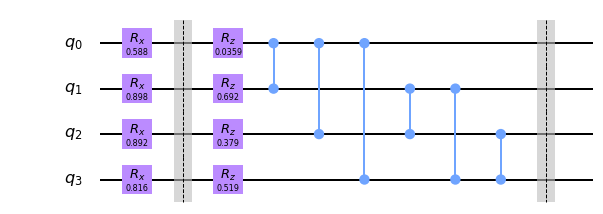

In [4]:
def get_var_form(LAYERS, params):
    
    circ = QuantumCircuit(4)
    
    for i in range(LAYERS):
        circ = circ + oddblock(params[8*i:8*i+4])
        circ = circ + evenblock(params[8*i+4:8*i+8])
        
    return circ

params = np.random.rand(8*1)

# visualizing complete circuit to check
get_var_form(1, params).draw(output='mpl')

# Optimizing 

## Creating Target State

In [7]:
#creating random target state
target_state = np.random.rand(16) + np.random.rand(16)*1j

#normalizing target state
target_state = target_state/(np.linalg.norm(target_state))

## Configuring Simulator

In [8]:
# Import Aer
from qiskit import Aer, execute

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('statevector_simulator')

## Creating Cost Function

In [9]:
def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    circ = get_var_form(LAYERS, params)
    
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(circ, backend).result()
    output_state = result.get_statevector(circ)
    
    # cost
    cost = np.linalg.norm(output_state - target_state)
    return cost

LAYERS = 1
params = np.random.rand(8*LAYERS)
objective_function(params)

1.2776183441948266

## Running optimizer

In [10]:
from qiskit.aqua.components import optimizers

# for timing the optimization sessions 
import time

In [11]:
def optimize_circuit(params, LAYERS, iteration, bounds):

    # Initialize the COBYLA optimizer
    optimizer = optimizers.COBYLA(maxiter=iteration, tol=0.0001)
    
    # run optimizer
    ret = optimizer.optimize(num_vars=len(params), objective_function=objective_function, 
                             variable_bounds=bounds, initial_point=params)
    
    return ret[0], ret[1]
    

**Note**: The following code-block generates error-results for simulations. You can change the number of optimizer-iterations and the maximum layer count up to which you want to simulate, in the first line. 

For 1000 optimizer iterations, and simulating up to 10 layers, the following code-block needs approximately **4** minutes to run. 

In [13]:
# no. of iterations and maximum no. of layers
# change these two variables if required
iteration, max_layer_count = 1000, 10

print("Running", iteration, "optimizer iterations per session...")
# timing each iteration
iter_start = time.time()

# simulation results will be stored in this list
data = []

for LAYERS in range(1, max_layer_count+1):
    print("Optimizing a", LAYERS, "layer circuit...")
    layer_start = time.time()
    
    # Creating random initial parameters in the range of 0 to 2pi
    params = np.random.rand(8*LAYERS)*2*np.pi
    # bounds of the parameters
    bounds = [(0, 2*np.pi)]*len(params)

    # optimizing circuit for the given number of layers
    solution, error = optimize_circuit(params, LAYERS, iteration, bounds)
    print(iteration, "iterations", LAYERS, "layers... Optimized! \n", round(time.time()-layer_start), "seconds for this layer.")

    data.append([LAYERS, error, solution])

print("All circuits optimized for", iteration, "iterations! \n\n", 
      round(time.time()-iter_start), "seconds for running", iteration, "iterations per session.\n\n")

final_result = [[iteration, data]]

Running 1000 optimizer iterations per session...
Optimizing a 1 layer circuit...
1000 iterations 1 layers... Optimized! 
 1 seconds for this layer.
Optimizing a 2 layer circuit...
1000 iterations 2 layers... Optimized! 
 9 seconds for this layer.
Optimizing a 3 layer circuit...
1000 iterations 3 layers... Optimized! 
 15 seconds for this layer.
Optimizing a 4 layer circuit...
1000 iterations 4 layers... Optimized! 
 19 seconds for this layer.
Optimizing a 5 layer circuit...
1000 iterations 5 layers... Optimized! 
 21 seconds for this layer.
Optimizing a 6 layer circuit...
1000 iterations 6 layers... Optimized! 
 25 seconds for this layer.
Optimizing a 7 layer circuit...
1000 iterations 7 layers... Optimized! 
 30 seconds for this layer.
Optimizing a 8 layer circuit...
1000 iterations 8 layers... Optimized! 
 37 seconds for this layer.
Optimizing a 9 layer circuit...
1000 iterations 9 layers... Optimized! 
 45 seconds for this layer.
Optimizing a 10 layer circuit...
1000 iterations 10 l

## Plot Results for Comparison

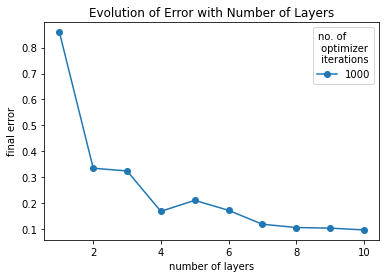

In [14]:
import matplotlib.pyplot as plt

# function to plot results for comparison 
def plot_result(max_layer_count, results):

    layer_list = [i for i in range(1, max_layer_count+1)]

    for iter_data in results:
        iter_num, error = iter_data[0], ([i[1] for i in iter_data[1]])

        plt.plot(layer_list, error, label=str(iter_num), marker='o', ls='-')

    plt.xlabel('number of layers')
    plt.ylabel('final error')

    plt.title('Evolution of Error with Number of Layers')

    plt.legend(loc="lower right", bbox_to_anchor=(1.2, 0), title='no. of \n optimizer\n iterations')
    plt.show()


plot_result(10, final_result)

You can use the following code-block to see the simulation results for a particular number of layers. Just change the "*layers*" variable below. 

In [16]:
# change the layer variable to the number of layers for which you want to see the result
layer = 10


solution = final_result[0][1][layer-1][2]

# Obtain a quantum circuit instance from the paramters
circ = get_var_form(layer, solution)

# Create a Quantum Program for execution
result = execute(circ, backend).result()
output_state = result.get_statevector(circ)

# cost
error = np.linalg.norm(output_state - target_state)

print("Target State:", target_state)
print("Output State:", output_state)
print("Error:", error)

Target State: [0.03855949+0.08881887j 0.24824809+0.02224631j 0.07904564+0.25491109j
 0.08419637+0.15893313j 0.28338796+0.10878073j 0.31383853+0.16873276j
 0.18559999+0.08711172j 0.05907502+0.10260333j 0.25451682+0.20713319j
 0.16269905+0.18419993j 0.20858698+0.10526927j 0.27739799+0.13046931j
 0.15234273+0.08524337j 0.16453594+0.1923918j  0.2245    +0.05340749j
 0.21504128+0.19764328j]
Output State: [0.04015296+0.06821691j 0.25933728+0.00211812j 0.07603901+0.25522861j
 0.11315452+0.16818522j 0.2939607 +0.11950309j 0.2993409 +0.17599192j
 0.19345045+0.08086735j 0.05796361+0.08110737j 0.2458503 +0.21481235j
 0.18192703+0.20546085j 0.20057943+0.08622686j 0.25346224+0.12654189j
 0.12781425+0.06011533j 0.12844149+0.17739593j 0.26450263+0.05516388j
 0.22309357+0.19690994j]
Error: 0.09665553960654465


## Additional

The following block of code can be run to see the dependence of final error on the numbmer of optimization iterations. You can change the list ITER_LIST below, to see the results for a particular number of iterations. 

**Note:** For the given max_layer_count and ITER_LIST, the code-block requires approximately **30** minutes to run. 

Running 100 optimizer iterations per session...
Optimizing a 1 layer circuit...
100 iterations 1 layers... Optimized! 
 1 seconds for this layer.
Optimizing a 2 layer circuit...
100 iterations 2 layers... Optimized! 
 1 seconds for this layer.
Optimizing a 3 layer circuit...
100 iterations 3 layers... Optimized! 
 2 seconds for this layer.
Optimizing a 4 layer circuit...
100 iterations 4 layers... Optimized! 
 2 seconds for this layer.
Optimizing a 5 layer circuit...
100 iterations 5 layers... Optimized! 
 2 seconds for this layer.
Optimizing a 6 layer circuit...
100 iterations 6 layers... Optimized! 
 2 seconds for this layer.
Optimizing a 7 layer circuit...
100 iterations 7 layers... Optimized! 
 3 seconds for this layer.
Optimizing a 8 layer circuit...
100 iterations 8 layers... Optimized! 
 3 seconds for this layer.
All circuits optimized for 100 iterations! 

 16 seconds for running 100 iterations per session.


Running 250 optimizer iterations per session...
Optimizing a 1 layer 

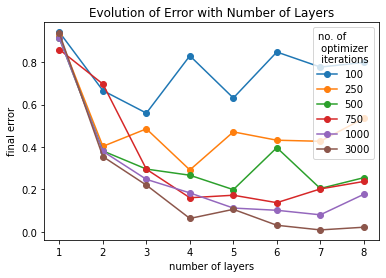

In [17]:
max_layer_count = 8
ITER_LIST = [100, 250, 500, 750, 1000, 3000]

iter_results = []
for iteration in ITER_LIST:
    print("Running", iteration, "optimizer iterations per session...")
    
    # results for each iteration will be stored in this list
    data = []
    
    # timing each iteration
    iter_start = time.time()

    for LAYERS in range(1, max_layer_count+1):
        print("Optimizing a", LAYERS, "layer circuit...")
        layer_start = time.time()
        # Creating random initial parameters in the range of 0 to 2pi
        params = np.random.rand(8*LAYERS)*2*np.pi

        # bounds of the parameters
        bounds = [(0, 2*np.pi)]*len(params)

        # optimizing circuit for the given number of layers
        solution, error = optimize_circuit(params, LAYERS, iteration, bounds)
        print(iteration, "iterations", LAYERS, "layers... Optimized! \n", round(time.time()-layer_start), "seconds for this layer.")

        data.append([LAYERS, error, solution])

    print("All circuits optimized for", iteration, "iterations! \n\n", 
          round(time.time()-iter_start), "seconds for running", iteration, "iterations per session.\n\n")

    iter_results.append([iteration, data])

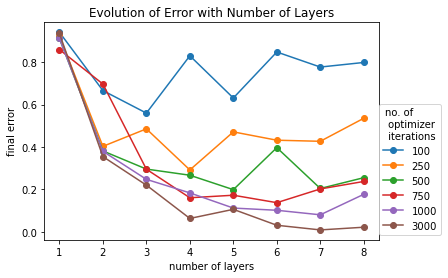

In [18]:
plot_result(max_layer_count, iter_results)